#notebooks.parameterized_grover_state_preparation_1d

## Setup

In [69]:
!pip install qiskit qiskit_aer

In [70]:
from qiskit_aer import Aer
from qiskit.circuit.library import RYGate
from qiskit import QuantumCircuit, QuantumRegister, transpile

In [71]:
import numpy as np
from itertools import product
from scipy.stats import beta, chisquare, entropy, wasserstein_distance
import matplotlib.pyplot as plt

In [72]:
backend = Aer.get_backend("aer_simulator")

## Utilities

In [73]:
def get_grover_angles(p_i_set, m):
    """Calculates Grover's angles for a given set of probabilities.

    Args:
        p_i_set (list or array-like): A list of probabilities corresponding to quantum states.
        m (int): The number of qubits used in the quantum circuit.

    Returns:
        list: A list of rotation angles required for Grover's state preparation.

    Raises:
        ValueError: If the computed number of angles does not match the required length for m qubits.
    """
    thetas = []
    p_i_set = list(p_i_set)
    for j in range(m):
        while len(p_i_set) % 2**(j + 1) != 0:
            p_i_set.append(0)
        current_p = np.array(np.array_split(p_i_set, 2**(j + 1))).sum(axis=1)
        if j > 0:
            for i in range(len(previous_p)):
                if previous_p[i] == 0:
                    previous_p[i] = 1e-5
                theta = 2 * np.arccos(np.sqrt(current_p[i * 2] / previous_p[i]))
                thetas.append(theta)
        else:
            theta = 2 * np.arccos(np.sqrt(current_p[0]))
            thetas.append(theta)
        previous_p = current_p
    required_length = 2**m - 1
    if len(thetas) != required_length:
        raise ValueError(f"The number of angles in 'thetas' must be {required_length} for {m} qubits.")
    return thetas

# Test
#m = 2
#n = 2**m
#num_bins = m +1
#p_i_set = [0.25]*n
#angles = get_grover_angles(p_i_set, m)
#print(f"Angles: {angles} \nDimensionality check: {len(angles)==num_bins}")

In [74]:
def state_expansion(m, thetas):
    """Constructs a quantum circuit that applies rotations based on the calculated angles.

    Args:
        m (int): The number of qubits in the circuit.
        thetas (list): A list of rotation angles computed for Grover's algorithm.

    Returns:
        QuantumCircuit: A quantum circuit implementing the state preparation.

    Raises:
        ValueError: If the number of angles does not match the required 2^m - 1.

    References:
        - https://arxiv.org/pdf/quant-ph/0208112
    """
    if len(thetas) != 2**m - 1:
        raise ValueError("The number of angles in 'thetas' must be 2^m - 1 for m qubits.")
    qc = QuantumCircuit(m, m)
    qc.ry(thetas[0], 0)
    theta_index = 1
    for qubit in range(1, m):
        control_combinations = list(product([0, 1], repeat=qubit))
        for combination in control_combinations:
            for ctrl, state in enumerate(combination):
                if state == 0:
                    qc.x(ctrl)
            qc.append(RYGate(thetas[theta_index]).control(len(combination)), list(range(qubit)) + [qubit])
            theta_index += 1
            for ctrl, state in enumerate(combination):
                if state == 0:
                    qc.x(ctrl)
    qc.measure(range(m), range(m)[::-1])
    return qc

# Test
#m = 2
#n = 2**m
#p_i_set = [0.25]*n
#angles = get_grover_angles(p_i_set, m)
#qc = state_expansion(m, angles)
#qc.draw()

## Applications

### 1d (beta) distribution

In [75]:
alpha = 2
beta_ = 2
m = 4
a = 0
b = 1
N = 1024
nu = 0.4

In [76]:
p_i_set = beta.pdf(np.linspace(a, b, 2**m-1), alpha, beta_)
p_i_set /= p_i_set.sum()

In [77]:
thetas = get_grover_angles(p_i_set,m)
qc = state_expansion(m,thetas)
t_qc = transpile(qc, backend=backend)
job = backend.run(t_qc, shots=N)
counts = job.result().get_counts(qc)
total_counts = sum(counts.values())
samples = {key: value / total_counts for key, value in counts.items()}


In [81]:
num_states = 2**m-1
all_states = [format(i, f"0{m}b") for i in range(num_states)]
samples_full = {state: samples.get(state, 0) for state in all_states}
y = np.array([samples_full[state] for state in all_states])
y /= y.sum()

In [82]:
chi_stat, chi_p = chisquare(y, f_exp=p_i_set)
kl_div = entropy(y, p_i_set)
emd = wasserstein_distance(y, p_i_set)
print(f"Chi-Square Test: statistic={chi_stat}, p-value={chi_p}")
print(f"KL Divergence: {kl_div}")
print(f"Earth Mover's Distance: {emd}")

Chi-Square Test: statistic=nan, p-value=nan
KL Divergence: 0.0017939373349941641
Earth Mover's Distance: 0.002980196886446883


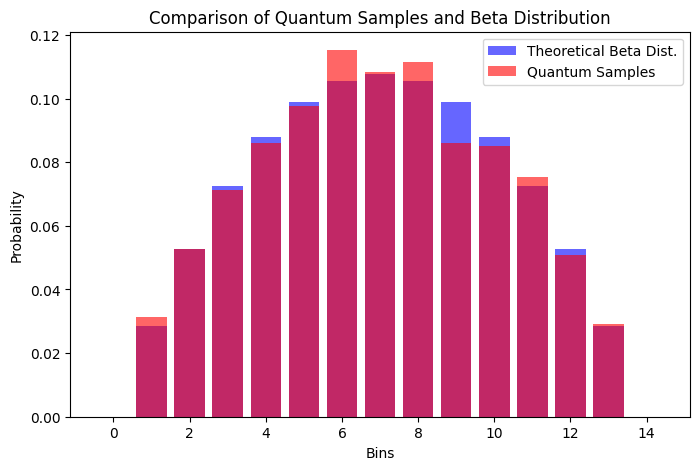

In [83]:
# Visualization
plt.figure(figsize=(8, 5))
plt.bar(range(len(p_i_set)), p_i_set, alpha=0.6, label='Theoretical Beta Dist.', color='blue')
plt.bar(range(len(y)), y, alpha=0.6, label='Quantum Samples', color='red')
plt.xlabel("Bins")
plt.ylabel("Probability")
plt.legend()
plt.title("Comparison of Quantum Samples and Beta Distribution")
plt.show()


In [80]:
#y = list(samples.values())
#y /= np.array(y).sum()
#x = range(len(samples))
#plt.scatter(x, y)
#plt.plot(p_i_set, color="red")
#plt.show()